# Task 3 - Processing data - K-folding - Precision Recall Curve

# Manage Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from imblearn.over_sampling import SMOTE as smote
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss, AllKNN, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier

from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Parsing data

In [2]:
#Parse CSV file
data = pd.read_csv('assignment-data/data_for_student_case.csv', dtype={'bin':str, 'amount':int}, na_filter=False)

# Skip data if:
data = data[data['simple_journal']!='Refused']
data = data[~data['bin'].str.contains('na', case=False)]
data = data[~data['mail_id'].str.contains('na', case=False)]

# Drop some columns
data.drop(columns = ['bookingdate', 'creationdate', 'txid'], inplace=True)

# Rename some columns
data = data.rename(index=str, columns={'bin':'issuer_id', 
                                       'issuercountrycode':'issuercountry', 
                                       'shoppercountrycode':'shoppercountry', 
                                       'cardverificationcodesupplied':'verification', 
                                       'cvcresponsecode':'cvcresponse', 
                                       'shopperinteraction' : 'interaction', 
                                       'simple_journal':'label'})

# Parse data to new types
data['card_id'] = pd.to_numeric(data['card_id'].str.replace('card','')).astype(int)
data['issuer_id'] = pd.to_numeric(data['issuer_id'])
data['mail_id'] = pd.to_numeric(data['mail_id'].str.replace('email','')).astype(int)
data['ip_id'] = pd.to_numeric(data['ip_id'].str.replace('ip','')).astype(int)
data['interaction'] = pd.to_numeric(data['interaction'].apply(lambda x: '1' if x == 'ContAuth' else '0'))
data['verification'] = pd.to_numeric(data['verification'].apply(lambda x: '1' if x else '0'))
data['label'] = pd.to_numeric(data['label'].apply(lambda x: '1' if x == 'Chargeback' else '0'))

# Preprocess data

### Creating new features that are indepentent of time and other transaction

In [3]:
# Check if issuercountry and shoppercountry are equal
data.loc[data['shoppercountry'] == data['issuercountry'], 'home_country'] = 1
data.loc[data['shoppercountry'] != data['issuercountry'], 'home_country'] = 0

# Dollar conversion rate
converter = {
    'AUD': 0.702495,
    'GBP': 1.305505,
    'MXN': 0.05274,
    'NZD': 0.6632,
    'SEK': 0.104965
}

# Function that can take two input values (amount, currency) and convert it to USD (using current ratios, not historic ones)
def convert_to_usd(args):
    amount, currency = args
    return converter[currency] * amount / 100

# Create a new column containing the transaction amount in USD to be able to compare the transaction amounts.
data['amount'] = data[['amount', 'currencycode']].apply(convert_to_usd, axis=1)

### Convert categorial data to integers

In [4]:
# Merge list of issuer and shopper countries so we have same categories for both lists
countries = pd.concat([data[['issuercountry','amount']].rename(columns = {"issuercountry": "country"}), data[['shoppercountry','amount']].rename(columns = {"shoppercountry": "country"})])
countries = countries.groupby('country')['amount'].agg(['count']).reset_index()
countries = countries['country'].tolist()
countries_type = pd.api.types.CategoricalDtype(categories=countries)
data['shoppercountry'] = data['shoppercountry'].astype(countries_type).cat.codes
data['issuercountry'] = data['issuercountry'].astype(countries_type).cat.codes

#Convert txvariantcode to int
txvariant = data.groupby('txvariantcode')['amount'].agg(['count']).reset_index()
txvariant = txvariant['txvariantcode'].tolist()
txvariant_type = pd.api.types.CategoricalDtype(categories=txvariant)
data['txvariantcode'] = data['txvariantcode'].astype(txvariant_type).cat.codes

# Convert accountcode to int
accounttype = data.groupby('accountcode')['amount'].agg(['count']).reset_index()
accounttype = accounttype['accountcode'].tolist()
accounttype_type = pd.api.types.CategoricalDtype(categories=accounttype)
data['accountcode'] = data['accountcode'].astype(accounttype_type).cat.codes

# Convert currencycode to int
currency = data.groupby('currencycode')['amount'].agg(['count']).reset_index()
currency = currency['currencycode'].tolist()
currency_type = pd.api.types.CategoricalDtype(categories=currency)
data['currencycode'] = data['currencycode'].astype(currency_type).cat.codes

## In-process data aggregation method

In [5]:
def calculate_features(data_train, data_test):
    #calculate average expense per card and overall based on training set
    avg_expense = data_train.groupby('card_id')['amount'].mean().reset_index().rename(columns={'amount': 'avg_amount'})
    avg_expense_overall = data_train['amount'].mean()
    
    # Merge avarages with training and test set (test set has no influence on training set this way)
    data_train = pd.merge(data_train, avg_expense, on='card_id', how='left')
    data_test = pd.merge(data_test, avg_expense, on='card_id', how='left')
    data_test['avg_amount'].fillna(avg_expense_overall, inplace=True)
    
    # Calculate difference between avarages and expenses for training and test set
    data_train['dif_avg_amount'] = data_train['amount'] - data_train['avg_amount']
    data_test['dif_avg_amount'] = data_test['amount'] - data_test['avg_amount']
    
    # Number of transactions in this country based on training set
    ntc = data_train.groupby(['card_id', 'shoppercountry'])['amount'].agg(['count']).reset_index().rename(columns={'count': 'ntc'})
    ntc_overall = data_train.groupby(['shoppercountry', 'card_id'])['amount'].agg(['count'])
    ntc_overall = ntc_overall.groupby(['shoppercountry'])['count'].mean()
    
    # Merge numer of transactions per country with training and test set (test set has no influence on training set this way)
    data_train = pd.merge(data_train, ntc, on=['card_id', 'shoppercountry'], how='left')
    data_test = pd.merge(data_test, ntc, on=['card_id', 'shoppercountry'], how='left')
    data_test['ntc'].fillna(0, inplace=True)
    
    # Number of transactions for this interaction based on training set
    nti = data_train.groupby(['card_id', 'interaction'])['amount'].agg(['count']).reset_index().rename(columns={'count': 'nti'})
    nti_overall = data_train.groupby(['interaction', 'card_id'])['amount'].agg(['count'])
    nti_overall = nti_overall.groupby(['interaction'])['count'].mean()
    
    # Merge numer of transactions per interaction with training and test set (test set has no influence on training set this way)
    data_train = pd.merge(data_train, nti, on=['card_id', 'interaction'], how='left')
    data_test = pd.merge(data_test, nti, on=['card_id', 'interaction'], how='left')
    data_test['nti'].fillna(0, inplace=True)
        
    return data_train, data_test

# KFold method including sampling and PR-curve

In [6]:
"""
This takes k folds, executes the sampling if a sampler is provided, 
calculates custom features on the training data,
and plots the PR curve of the specified Classifier.
"""
def KFold_PRC(data, folds, classifier,sampling=None):
    kf = KFold(n_splits = folds, shuffle = True)

    prob_lbl = []
    decision_lbl = []
    original_lbl = []

    for i, (i_train, i_test) in enumerate(kf.split(data)):
#         print("Fold: ", i+1)
        train_ft = data.iloc[i_train].drop(columns = ['label'])
        test_ft =  data.iloc[i_test].drop(columns = ['label'])
        train_lbl = data.iloc[i_train]['label']
        test_lbl = data.iloc[i_test]['label']
        
        #calculate features based on training set
        train_ft, test_ft = calculate_features(train_ft, test_ft)

        # perform sampling if sampler is given
        if sampling:
            train_ft_sample, train_lbl_sample = sampling.fit_sample(train_ft,train_lbl)
            classifier.fit(train_ft_sample, train_lbl_sample)
        else:
            classifier.fit(train_ft, train_lbl)

        # Add results to arrays
        decision_lbl.extend(classifier.predict(test_ft))
        prob_lbl.extend(classifier.predict_proba(test_ft)[:,1])
        original_lbl.extend(test_lbl)


    # Calculate precision and recall
    average_precision = average_precision_score(original_lbl, prob_lbl)
    precision, recall, _ = precision_recall_curve(original_lbl, prob_lbl)
    
    cm = confusion_matrix(original_lbl, decision_lbl)
    print(cm)

    fig = plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP=%f' %(average_precision))
    plt.show()

# Black box classifier

[[236174    179]
 [   305     40]]


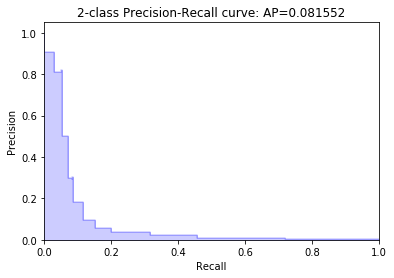

In [7]:
classifier = RandomForestClassifier(n_estimators=10)
sm = smote(sampling_strategy = 'minority')
KFold_PRC(data, 10, classifier,sm)

# White box classifier

[[235139   1214]
 [   292     53]]


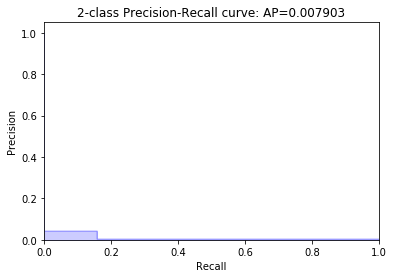

In [8]:
classifier = DecisionTreeClassifier()
sm = smote(sampling_strategy = 'minority')
KFold_PRC(data, 10, classifier, sm)